**YOUR NAMES HERE**

Spring 2020

CS 443: Computational Neuroscience

Project 3: Competitive Networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Overview of the working memory task

The purpose of this notebook is to take all the "bulding block" dynamics networks that you have played with and use them for a larger simulation. You will apply dynamic neural network equations to simulating human working memory storage and retrieval.

An example of this problem is giving you my phone number (you've never heard it before) and asking you to recall it back to me. There are 10 items to store temporarily in working memory: 207 550-4567. It's important to store their **order** (not only the **item identity** themselves) — e.g. 2, then 0, then 7, ...

Task 5 **recalls/extracts items already stored from working memory in the correct order**. Task 6 is concerned with getting items queued up in **working memory storage** (STORE2 network). **In light of timing constraints, this is now a suggested extension.**

**NOTE:** You are welcome to use your language of choice to implement the neural networks (i.e. Python or MATLAB). These instructions are provided in a Jupyter notebook in case you have trouble accessing MATLAB.

There are no code templates for this part — you may design the network how ever you like. In each task, there are key plots that you are asked to replicate to show that everything is working.

## Task 5) Serial Recall: Competitive Queuing

### Overview of the serial recall task

In this task, you will create a 3 level network (one is a winner-take-all RCF) called a **competitive queuing model (CQ)** that will retrieve each item in the appropriate order from working memory (if we have 4 items in working memory, ABCD, the CQ should retrieve A then B then C then D).

You can download from the website use the output from $x$ at the last time step from STORE2 to initialize this new CQ network that will perform the list recall. *If you do the Task 6 extension, you can compute these memory gradients yourself.*

### Competitive Queuing network

This network consists of three interconnected layers.
- There is an working memory layer $x$ (first layer) like before
- a second layer $y$ which is a RCF with a faster-than-linear signal function such that it creates winner-take-all dynamics
- and there is another layer of **inhibitory interneurons** $w$ will are in charge of inhibiting / shutting down cells coding an item from working memory after it gets recalled (i.e. the item has been recalled and can't interfere with recall of later items). 

Here is a brief review of the neural network dynamics. Cells in $x$ initially encode the primacy gradient from STORE2. At some point that you choose, a GO signal occurs ($J$ flips from 0 to 1). This prompts recall of the list in working memory. Cells in the RCF ($y$) start to compete. The RCF cell $y_k$ encoding Item 1 wins the competition (1st item has the highest activity). This activates the inhibitory neuron $w_k$, which suppresses $x_k$ to 0. Without any input, the winner RCF cell $y_k$ activity drops down. The working memory cells $x_i$ re-normalize activity, bringing everybody up. Now the RCF cell for the 2nd item $y_m$ gets the most input $x_m$, which makes it win the competition. It then activates $w_m$, which suppresses $x_m$ and the cycle continues until all items have been recalled from the network. 

Here are the equations for each layer:

$$\frac{x_i}{dt} = -A_xx_i + (B_x - x_i)f(x_i)- x_i  \left (\sum_{j\neq i}x_j +Dw_i \right )$$

$$\frac{y_i}{dt} = -A_yy_i + (B_y-y_i)(y_i^2+Jx_i) - (C_y+y_i)\left (\sum_{j\neq i}y_j^2 \right )$$

$$\frac{w_i}{dt} = -A_ww_i + (B_w - w_i)\text{max}(y_i - \Gamma, 0)$$

$$f(x_i) = 1/\left (\epsilon + \sum_{j=1}^Nx_j \right )$$

Above, the parameters follow the usual conventions with the following notes:
- $D$ regulates the inhibitory feedback strength from the interneurons.
- $J$ is 1 if the GO signal has been turned on and is 0 otherwise. The GO signal turns at at a time $t_{go}$ of your choosing to initiate recall of the list. $J$ should be 1 for ALL times after $t_{go}$.
- $\epsilon$ is a small number to prevent division by 0 if all the working memory cells are 0.
- $\Gamma$ is a threshold: the amount of RCF activity needed for a clear winner to be established so that the corresponding item in working memory can be triggered for recall to initiate the suppression of the working memory representation. 

A few more guidelines/suggestions:
- The initial conditions for the $x_i$ cells should be set to the STORE2 primacy gradient final values. **I suggest explicitly normalizing these initial values so that they all sum to 1 before setting the initial conditions.**
- After working memory units are suppressed (following recall), it might be helpful to "tag" these cells so that they are hard-coded to 0 (i.e. manually shut off) for all later times based on the cell index of each winner. That way, you don't have to worry about them potentially becoming active again interfering with the other cells. I would caution against a hard threshold value to check against because it won't allow your network to scale if you want to more items for your network to remember.

### Goals

The design of the network and parameters are up to you. The goal is to get the network to recall items from working memory robustly for for lists at least of length 3-6 items. Here is an example of a plot that you can try to emulate from Boardman & Bullock (1991) (annotations are mine to highlight key parts of the plot):

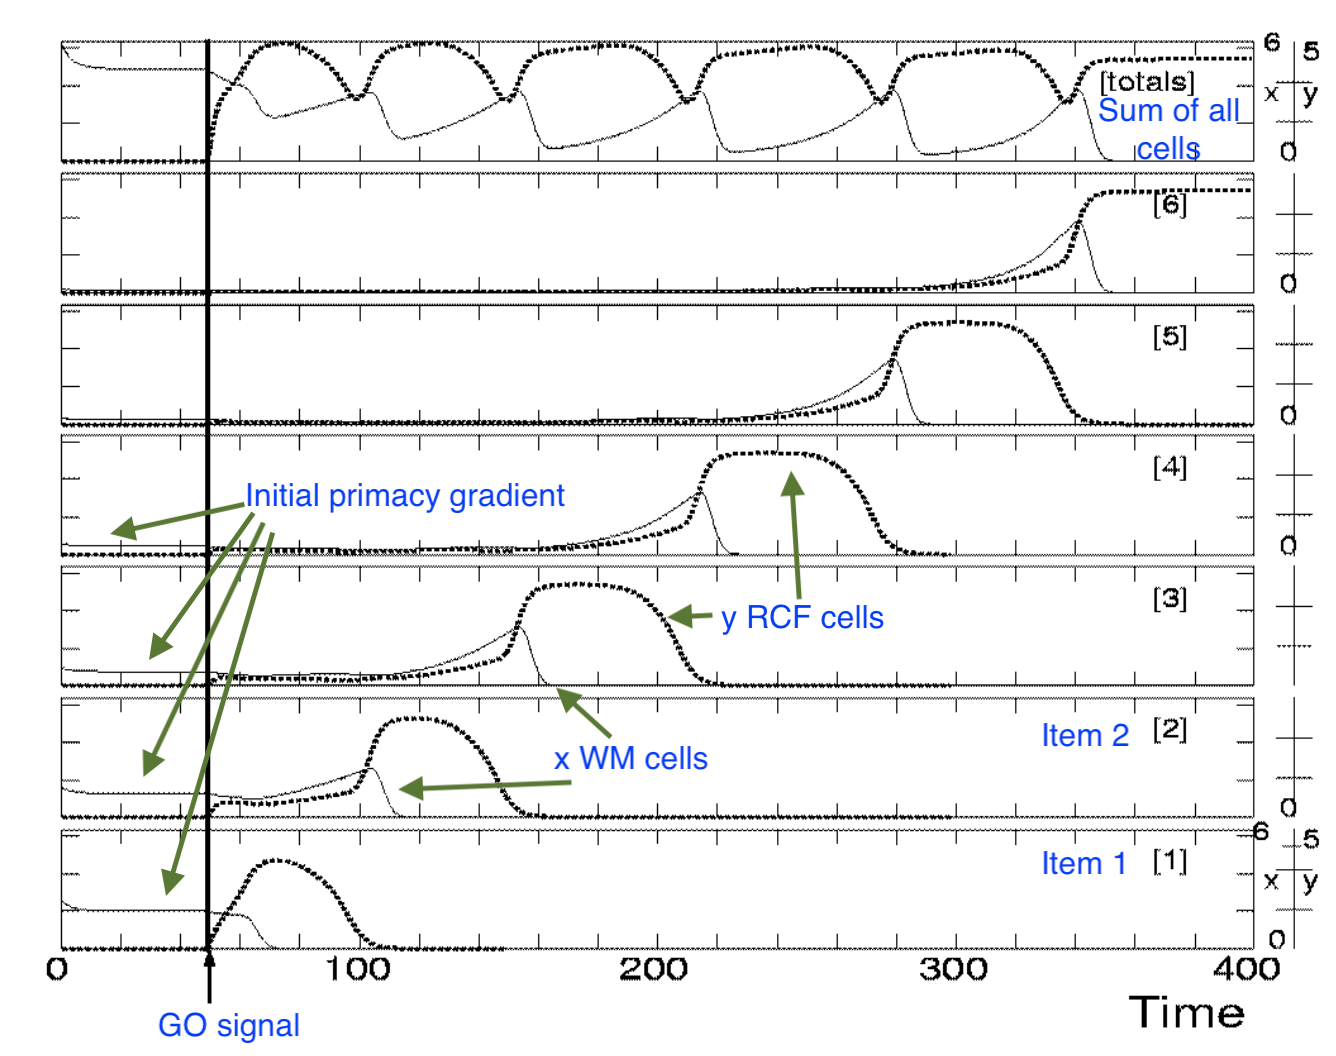

An important learning outcome is learning how to debug a complex interacting system. This involves picking parameters to make the network achieve the goal based on the meaning of each parameter. However, I don't want you to spend hours tuning parameters. Here are some suggestions:
- Use "reasonable" values in ranges that you're used to seeing.
- Start simple with 1-2 items, get it working, then increase from there.
- The feedback strength from inhibitory interneurons ($w_i$) and working memory units ($x_i$) should be very strong. You want the interneuron to very quickly suppress the working memory activation $x_i$.
- The inhibitory interneuron decay rate should be very small: If we are suppressing a working memory item, we want to suppress it for future times so that it doesn't reactivate for some reason.
- The RCF ($y$) to inhibitory interneuron threshold ($w$) should be set based on what you see as an activity level RCF *winners* achieve, but the losers do not (hitting this threshold means a snowball effect is triggered).
- If your RCF is getting input from the working memory cells appropriately, but a clear winner isn't emerging, try increasing B.
- If your RCF winner isn't dropping back to 0, try increasing C.
- When plotting, restrict the y axis to positive values (e.g. RCF winners will drop down to negative values and you probably want to focus on the positive activity).
- If using MATLAB, use the MATLAB debugger to enter the network integration loop at certain time steps where you "need" something to happen (e.g. if $t > 50$ stop at a break point), then adjust parameters based on what you discover in the debugger (you need an RCF cell to get higher activity so you increase B, you need the RCF cell to decay back to 0 so you increase C, etc).
- Everyone's time scale will differ depending on parameter choices — there are many, many valid parameter combinations that will let the network operate effectively.

If you are spending too much time on tuning parameters, please see the parameter hints file (cq_parameter_hints_1.txt) for some values that work so you have fewer parameters to play with. If that's not enough and you're still not having luck, check out (cq_parameter_hints_2.txt) for more parameters.

### Plots

You should submit the following plots inline in this notebook or in your submission folder:

- Figure showing the working memory cells and RCF cells over time (and maybe the interneurons too) in a number of rows equal to the number of items in memory. The figure should look roughly like the one above. Like before, there's no need to reproduce magnitudes, timing of recall events, etc. The important thing is to get the general picture/dynamics working for parameters that you discover.
    - All items queued up into working memory should be dynamically dequeued in the appropriate order.
    - Each panel should show the RCF cells "spiking", which corresponds to the item being recalled, and the working memory representation dropping to 0 afterwards.
    - A "Totals" row (summed activity across all cells) is optional.

### Questions

**Question 16:** What happens when you "pause" the GO signal for some period of time after it goes on (i.e. set it to 0 manually for some period of time after it is 1, then bring it back to 1 after this pause period is over)?

**Question 17:** Is there a limit on how many items can your network recall?

### Answers

**Answer 16:** Fill me in

**Answer 17:** Fill me in

## Task 6) Working Memory Storage: STORE2 network [EXTENSION]

You will implement the STORE2 model from Bradski et al. (1994) that encodes each item and order in a type of neural signal called a **primacy gradient**. The STORE2 network consists of two dynamically interacting layers of neurons. The first one  is the working memory representation we're interested in. The second layer  tracks the first one and you can think of as a "helper" layer. Here are the equations:

$$\frac{dx_i}{dt} = I \left (AI_i + y_i - Xx_i - Bx_i \right )$$
$$\frac{dy}{dt} = E\left ( x_i - y_i \right ) \left (1 - I \right )$$

where:

- $x_i$ is the activation of the $i^{th}$ working memory cell (layer 1) (in the telephone example $i$ would go from 1 to 10 since there are 10 items to encode)
- $A, B, E$ are parameters as we have discussed in class, 
- $y_i$ are the corresponding cell activities in the second layer (there are equal numbers of cells in the two layers), 
- $I$ is defined as the sum of all inputs currently on ($I = \sum_i^N I_i$), and 
- is the sum of all the working memory cell activites at the current time ($X = \sum_i^N x_i$).

### Input specification

We will assume that each item being presented to the network comes in one at a time with magnitude 1 (i.e. $I_i$ when the $i^{th}$ input turns on) and is 0 otherwise (when the item is not being presented). For example, the 1st item to be remembers comes first, followed by the second item, etc. There should be a small gap between items (like in real life) where all inputs are 0. The $j^{th}$ item in the sequence should be presented ONLY to the $i^{th}$ working memory unit  as follows, where  is defined in CONTINUOUS TIME UNITS (e.g. 0, 0.1, 0.2, ...):

$$I_j = 1\,\,\, \text{if} (j-1)(a+b) < t < j*a+(j-a)b$$
$$0 \text{ otherwise}$$

In the above input equation, $a$ is the duration that each item is presented and $b$ is the gap/interval between two subsequent item presentations.

### Goals

Your goal is to implement STORE2 and create primacy gradient encoding 3 items, like the one in the following figure. 

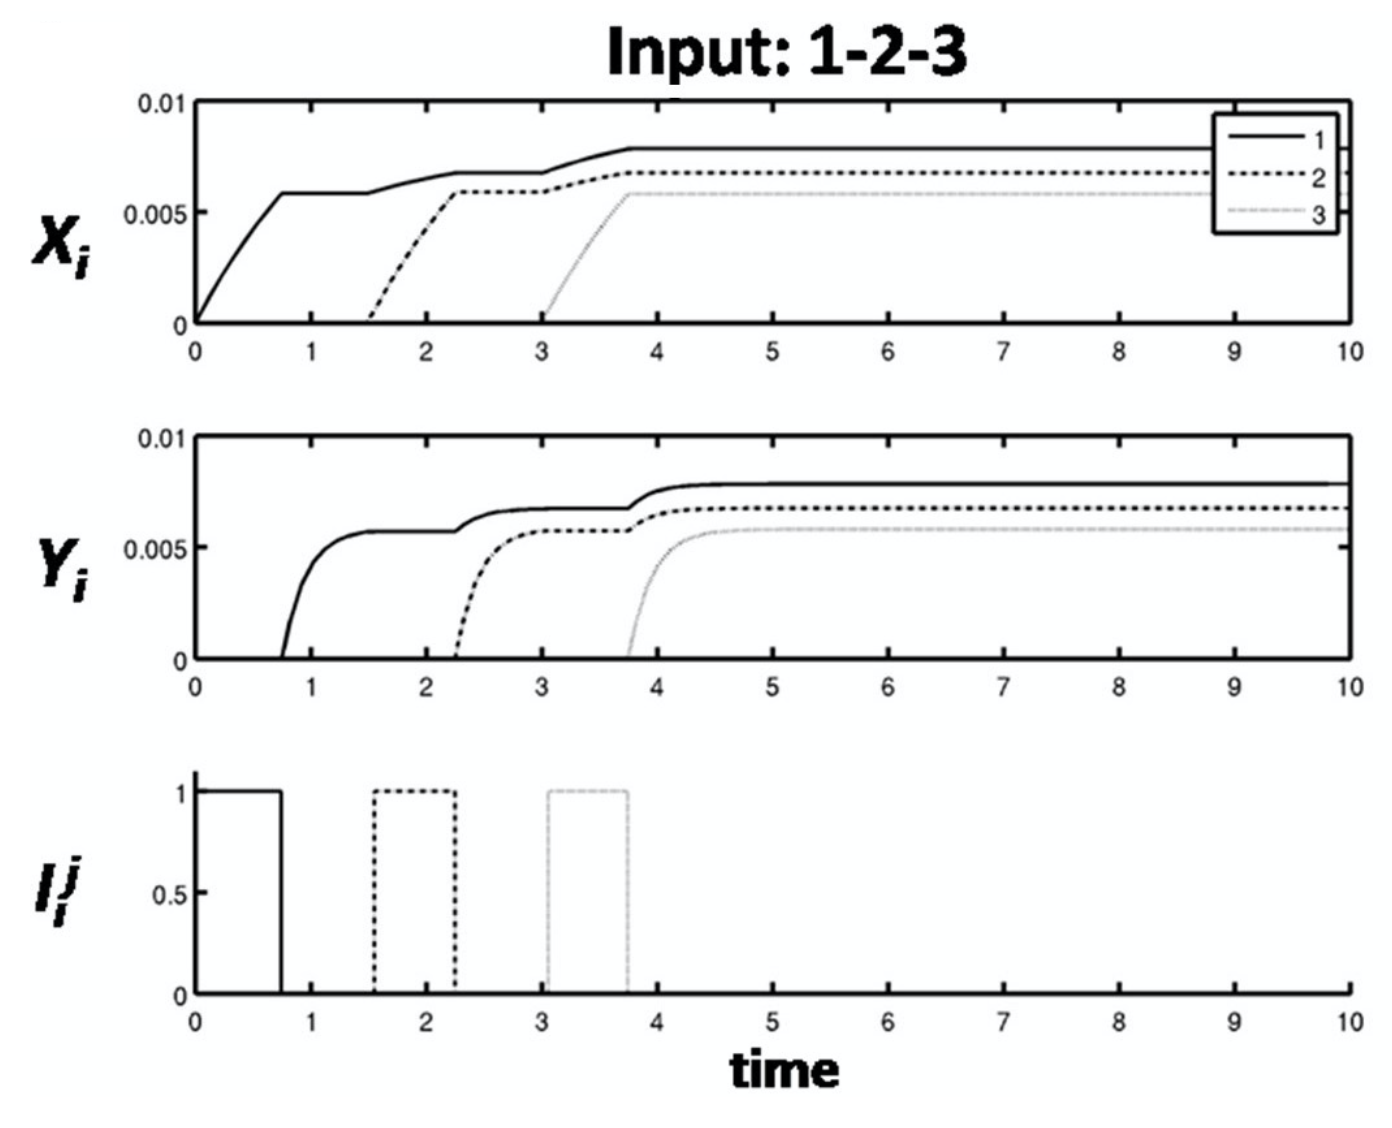

As mentioned at the top, the design of the network is up to you. Ultimately, however, you should compute/return variables reflected in the plot:

- `I_i(t)`: The input signal history presented to working memory cell $i$ at all times (square waves in above plot).
- `x(t)`: the activity of the working memory cells at ALL time steps of the simulation.
- `y(t)`: same thing, but for the y cells

*There's no need to try and match the exact magnitudes or durations (except the inputs still should be either 0/1)*. You do need to get the shape correct (i.e. clearly encode a primacy gradient). Your network should work with any reasonable number of working memory items > 0, not just 3.

### Deliverable plots

You should submit the following plots inline in this notebook or in your submission folder:

1. 3 row figure showing the inputs, working memory cells, and y cells over time (like figure above). You should show a clear primacy gradient in the x and y cells.
2. After all your inputs are shut off and your network establishes a primacy gradient, take the $x$ values at the final time step and normalize them so those values sum to 1. You should now have a $N$ normalized values ($N$ = number of items).
    - Create a bar plot showing the relative magnitudes in sequence order (activation to item 1 on the left, activation to item 2 next to it, etc). Your plot should show a clear primacy gradient (item 1 has the highest activity, item 2 has the next highest, etc.). The x axis should should item number and y axis should show network activation to it.
3. Play with your network parameters and create a plot with a **recency gradient**, which means that the LAST item garners the highest activity, followed by the second-to-last item, etc.
4. Play with the parameters once again and create a plot showing a **bowing gradient**, which means that the bars look "U-shaped": the largest values are either at the beginning or end of the list and decrease toward the middle.

### Questions

**Question 18:** What role does the parameter B play in the primacy gradient? 

**Question 19:** What does it mean for list item sequence encoding when the network shows a bowing gradient? Give a real-life example where this probably happens.

**Question 20:** Does there seem to be a limit on the number of items that can be stored in working memory in a primacy gradient using STORE2? Why or why not?

**Question 21:** Name one problem may arise for later retrieval if the number of items becomes very large. Does this make sense based on your experience of holding information in working memory?

### Answers

**Answer 18:** Fill me in

**Answer 19:** Fill me in

**Answer 20:** Fill me in

**Answer 21:** Fill me in

## Extensions

### 0. STORE2 network

Some or all of Task 6 above.

### 1. STORE2 primacy gradient
Experiment with the timing, number of items, duration of the items. Is the network robust to these changes?
Try presenting multiple items at the same time to STORE2. What happens?
Come with a scheme for creating primacy gradients for lists with repeat items (hint: the Bradski paper has some methods for doing this).

### 2. Serial recall timing
Analyze the timing of when items are retrieved from working memory. Is the distribution uniform? Does the distribution make sense?
Analyze how changes to the parameters affect the timing and quality of item recall.

### 3. Serial recall with different working memory representations
Experiment with competitive queuing with bowed and recency gradients. How happens and does it make sense?

### 4. Other visual illusions

Look up other grayscale brightness-related visual illusions online and simulate them with your networks (e.g. convolutional, RCF, etc.) Is your network able to account for them? I suggest picking simple ones. 

### 5. Color image enhancement

Design a shunting network that enhances color images.

### 6. Simulate other network properties

Simulate properties of shunting networks from class that you have not directly simulated.